## Data Cleaning

In [65]:
import pandas as pd
import numpy as np
import regex as re
import seaborn as sns
from datetime import datetime
from scipy.interpolate import LSQUnivariateSpline
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta
from scipy.stats import norm, lognorm

# read excel file
df = pd.read_excel('C1Data.xlsx', sheet_name=None)

# name the sheets
bonds = df['Bonds']
yield_curve = df['YieldCurve']
rating = df['RatingDFRate2024']


# change columns to datetime
bonds['OFFERING_DATE'] = pd.to_datetime(bonds['OFFERING_DATE'])
bonds['MATURITY'] = pd.to_datetime(bonds['MATURITY'])
bonds['TRD_EXCTN_DT'] = pd.to_datetime(bonds['TRD_EXCTN_DT'])

#find the ones where the trade date is after the maturity date and remove them
bonds = bonds[bonds['TRD_EXCTN_DT'] < bonds['MATURITY']]

# get rid of the row where the principal amount is 1
bonds = bonds[~(bonds['PRINCIPAL_AMT'] == 1)]

# drop na in the yield_curve data
yield_curve.dropna(inplace=True)

# change the column names
yield_curve.columns = ['Date', '2024_data', '2025_data']

# make regex that only gets numbers and apply to the Date column
yield_curve['Date'] = yield_curve['Date'].apply(lambda x: re.findall(r'\d+', x)[0])

# change date column to numeric
yield_curve['Date'] = pd.to_numeric(yield_curve['Date'])/100

# change the data columns to numeric
yield_curve['2024_data'] = pd.to_numeric(yield_curve['2024_data'])
yield_curve['2025_data'] = pd.to_numeric(yield_curve['2025_data'])



## Plotting Yield Curve


Text(0, 0.5, 'Yield')

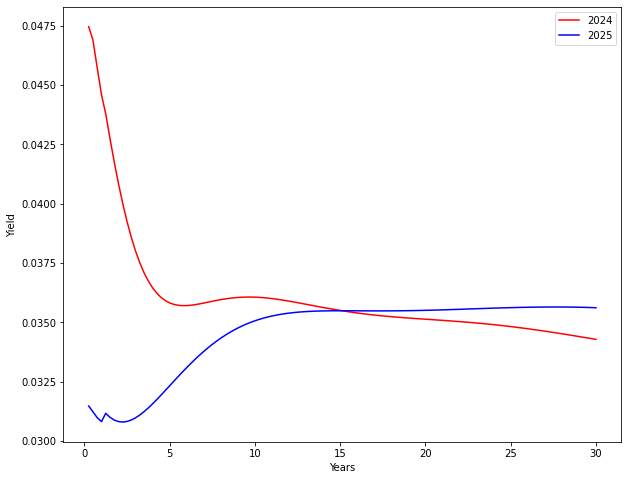

In [108]:
# plot the yield curve
plt.figure(figsize=(10, 8))

plt.plot(yield_curve['Date'], yield_curve['2024_data'], label='2024', color='red')
plt.plot(yield_curve['Date'], yield_curve['2025_data'], label='2025', color='blue')
plt.legend()

# axis labels
plt.xlabel('Years')
plt.ylabel('Yield')

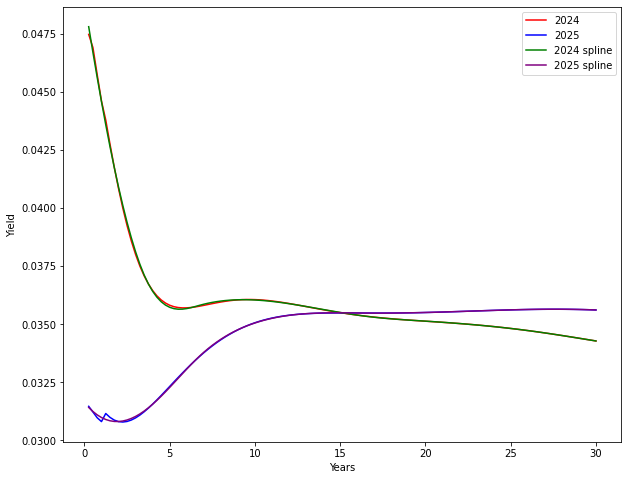

In [56]:
######### make model for splines to inteporlate the yield curve #########

# Define the positions of the knots (excluding the endpoints)
knots = np.linspace(yield_curve['Date'].min(), yield_curve['Date'].max(), 10)[1:-1]

# make the spline with specified knots
spline_2024 = LSQUnivariateSpline(yield_curve['Date'], yield_curve['2024_data'], t=knots, k=3)
spline_2025 = LSQUnivariateSpline(yield_curve['Date'], yield_curve['2025_data'], t=knots, k=3)

# make the plot
plt.figure(figsize=(10, 8))

plt.plot(yield_curve['Date'], yield_curve['2024_data'], label='2024', color='red')
plt.plot(yield_curve['Date'], yield_curve['2025_data'], label='2025', color='blue')

plt.plot(yield_curve['Date'], spline_2024(yield_curve['Date']), label='2024 spline', color='green')
plt.plot(yield_curve['Date'], spline_2025(yield_curve['Date']), label='2025 spline', color='purple')

plt.legend()

# axis labels
plt.xlabel('Years')
plt.ylabel('Yield')
plt.show()

## Question 1

In [105]:
# given a date and a list of cash flow dates, find the number of years to the next cash flow date
def years_to_next_date(date, cash_flow_dates):

    days_to_next = [(cash_flow_date - date).days for cash_flow_date in cash_flow_dates if cash_flow_date > date]

    return min(days_to_next)/365

# fuction that given a start date, end date and frequency returns a list of dates that are the cash flow dates
def cashflow_dates(start_date, end_date, frequency):
    dates = []
    current_date = start_date

    while current_date > end_date:
        dates.append(current_date.date())
        current_date -= relativedelta(months=12/frequency)

    return dates


# given a bond with its maturity date, coupon frequency, issue date and interest rate and principal amount make a df of all the cash flows and the number of years away each one is
def cashflows_and_years(offering_date, maturity_date, frequency, today, principal, interest_rate):

    # generate cashflow dates
    cash_flow_dates = cashflow_dates(maturity_date, offering_date, frequency)
    
    # remove all cash flows that are before today
    cash_flow_dates = [date for date in cash_flow_dates if date > today]

    # find the years to the next coupon date
    years_to_next_coupon = years_to_next_date(today, cash_flow_dates)

    # get the years to maturity of each cash flow, the first one is the number of days from today until the next coupon then each coupon is 12/frequency more
    years = np.arange(len(cash_flow_dates) - 1, -1, -1) * 1/frequency + years_to_next_coupon

    # combine cash flow dates and years into a df
    cash_flows = pd.DataFrame({'Date': cash_flow_dates, 'Years': years})

    # add cashflow amounts
    cash_flows['Amount'] = principal * interest_rate/frequency

    # add the principal to the last cashflow
    cash_flows.loc[cash_flows.index[0], 'Amount'] += principal

    return cash_flows

# a function that given the cashflows and the spline model of the yields discounts each one to the present value
def present_value(cash_flows, spline, spread=0):

    cash_flows['Discounted'] = cash_flows['Amount']/((1 + spline(cash_flows['Years']) + spread)**cash_flows['Years'])

    return sum(cash_flows['Discounted'])

# make a function that combines everything
def bond_value(offering_date, maturity_date, frequency, today, principal, interest_rate, spline, spread):

    cashflows = cashflows_and_years(offering_date, maturity_date, frequency, today, principal, interest_rate)
    
    return present_value(cashflows, spline, spread)

# set day to 2024-05
date_2024 = datetime(2024, 5, 31).date()

# apply the bond_value function to the bonds df
bonds['2024_value'] = bonds.apply(lambda x: bond_value(x['OFFERING_DATE'], 
                                                  x['MATURITY'], 
                                                  x['INTEREST_FREQUENCY'], 
                                                  date_2024, 
                                                  x['PRINCIPAL_AMT'], 
                                                  x['COUPON']/100, 
                                                  spline_2024, 
                                                  x['TREASURY_SPREAD']/100/100), axis=1)

bonds['years_to_maturity'] = bonds.apply(lambda x : cashflows_and_years(x['OFFERING_DATE'],
                                                                       x['MATURITY'],
                                                                       x['INTEREST_FREQUENCY'],
                                                                       date_2024,
                                                                       x['PRINCIPAL_AMT'],
                                                                       x['COUPON']/100)['Years'][0], axis=1)

# the total price of all the bonds in the canadian market
bonds['2024_value'].sum()

9739715.52458329

In [71]:
# the total price of all the bonds in the USA market
bonds['raw_reported_price'] = bonds['RPTD_LAST_PR'] * bonds['PRINCIPAL_AMT'] /100
bonds['raw_reported_price'].sum()


9417960.74751

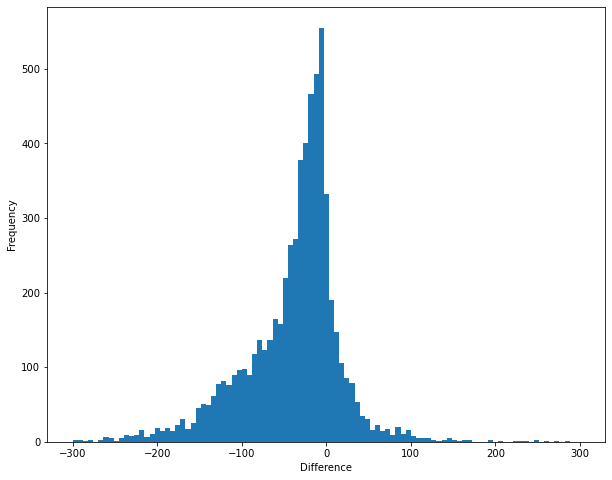

In [72]:
# take the difference between the usa prices and the canadian prices
bonds['difference'] = bonds['raw_reported_price'] - bonds['2024_value']

# histogram the differences only for a certain range
plt.figure(figsize=(10, 8)) 

plt.hist(bonds['difference'], bins=np.linspace(-300, 300, 100))

plt.xlabel('Difference')
plt.ylabel('Frequency')
plt.show()

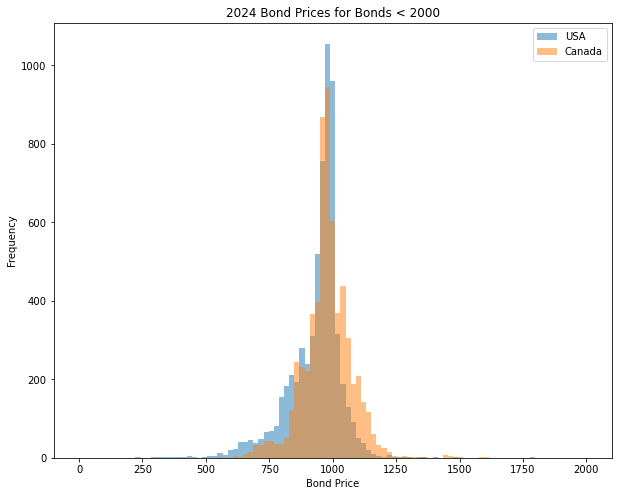

In [ ]:

# overlay the two histograms
plt.figure(figsize=(10, 8))

plt.hist(bonds[bonds['raw_reported_price']<2000]['raw_reported_price'], bins=np.linspace(0, 2000, 100), alpha=0.5, label='USA')
plt.hist(bonds[bonds['2024_value']<2000]['2024_value'], bins=np.linspace(0, 2000, 100), alpha=0.5, label='Canada')
plt.hist(bonds_2025['2025_value'], bins=np.linspace(0, 2000, 100), alpha=0.5, label='Canada 2025')

plt.xlabel('Bond Price')
plt.ylabel('Frequency')
plt.legend()
plt.title('2024 Bond Prices for Bonds < 2000')
plt.show()


## Question 2

In [59]:
# 2025 bond prices

# set day to jan 13, 2025
date_2025 = datetime(2025, 1, 13).date()

# remove the bonds that have already matured
bonds_2025 = bonds[bonds['MATURITY'] > datetime(2025,1,13)].copy()

# apply the bond_value function to the bonds df
bonds_2025['2025_value'] = bonds_2025.apply(lambda x: bond_value(x['OFFERING_DATE'], 
                                                  x['MATURITY'], 
                                                  x['INTEREST_FREQUENCY'], 
                                                  date_2025, 
                                                  x['PRINCIPAL_AMT'], 
                                                  x['COUPON']/100, 
                                                  spline_2025, 
                                                  x['TREASURY_SPREAD']/100/100), axis=1)

bonds_2025['years_to_maturity'] = bonds_2025.apply(lambda x : cashflows_and_years(x['OFFERING_DATE'],
                                                                       x['MATURITY'],
                                                                       x['INTEREST_FREQUENCY'],
                                                                       date_2025,
                                                                       x['PRINCIPAL_AMT'],
                                                                       x['COUPON']/100)['Years'][0], axis=1)


# sum of all the bond values
bonds_2025['2025_value'].sum()

9506016.551182697

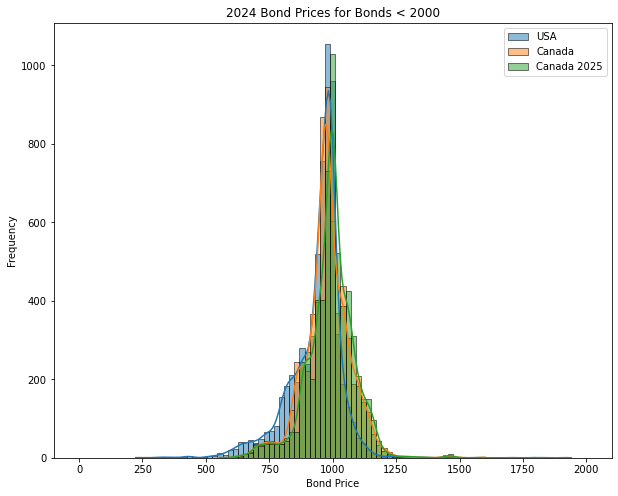

In [89]:

# overlay the histograms
plt.figure(figsize=(10, 8))

sns.histplot(bonds[bonds['raw_reported_price']<2000]['raw_reported_price'], 
         bins=np.linspace(0, 2000, 100), 
         alpha=0.5, 
         label='USA', 
         kde=True)

sns.histplot(bonds[bonds['2024_value']<2000]['2024_value'], 
         bins=np.linspace(0, 2000, 100), 
         alpha=0.5, 
         label='Canada',
         kde=True)


sns.histplot(bonds_2025[bonds_2025['2025_value']<2000]['2025_value'], 
         bins=np.linspace(0, 2000, 100), 
         alpha=0.5, 
         label='Canada 2025',
         kde=True)

plt.xlabel('Bond Price')
plt.ylabel('Frequency')
plt.legend()
plt.title('2024 Bond Prices for Bonds < 2000')
plt.show()

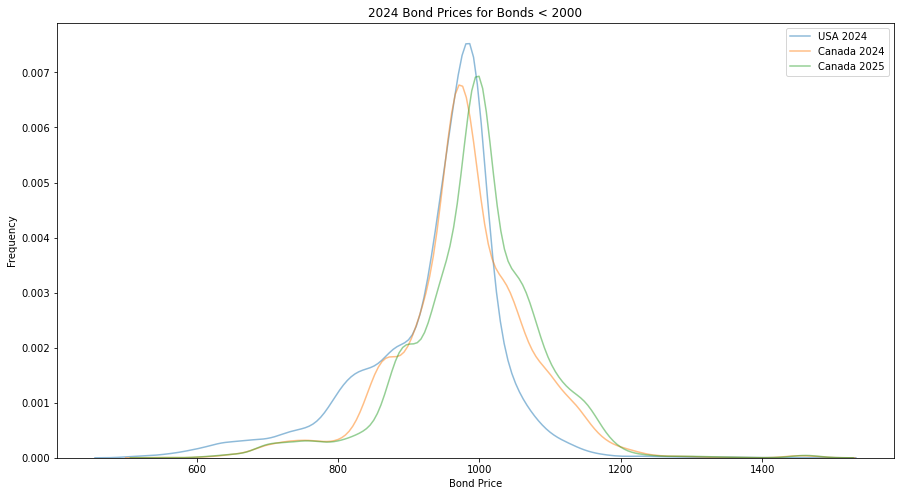

In [107]:

# overlay the histograms
plt.figure(figsize=(15, 8))

sns.kdeplot(bonds[(bonds['raw_reported_price']<1500) & (bonds['raw_reported_price']>500)]['raw_reported_price'], 
         alpha=0.5, 
         label='USA 2024')

sns.kdeplot(bonds[(bonds['2024_value']<1500) & (bonds['2024_value']>500)]['2024_value'], 
         alpha=0.5, 
         label='Canada 2024')


sns.kdeplot(bonds_2025[(bonds_2025['2025_value']<1500) & (bonds_2025['2025_value']>500)]['2025_value'], 
         alpha=0.5, 
         label='Canada 2025')

plt.xlabel('Bond Price')
plt.ylabel('Frequency')
plt.legend()
plt.title('2024 Bond Prices for Bonds < 2000')
plt.show()

In [ ]:
# Total value of bonds at given times
print(bonds_2025['raw_reported_price'].sum())
print(bonds_2025['2024_value'].sum())
print(bonds_2025['2025_value'].sum())


9006235.10294
9323774.733353583
9506016.551182697


## Question 3

Simulation 0/10000
Simulation 1000/10000
Simulation 2000/10000
Simulation 3000/10000
Simulation 4000/10000
Simulation 5000/10000
Simulation 6000/10000
Simulation 7000/10000
Simulation 8000/10000
Simulation 9000/10000

=== Descriptive Statistics for Exposure at Default (EAD) ===
count      6045.000000
mean       1563.688999
std       10539.653463
min         500.000000
5%         1000.000000
25%        1000.000000
50%        1000.000000
75%        1000.000000
95%        1000.000000
99%        1000.000000
max      200000.000000
dtype: float64

=== Descriptive Statistics for Loss Given Default (LGD) ===
count    6045.000000
mean        0.457196
std         0.045906
min         0.450000
5%          0.450000
25%         0.450000
50%         0.450000
75%         0.450000
95%         0.450000
99%         0.750000
max         0.750000
dtype: float64


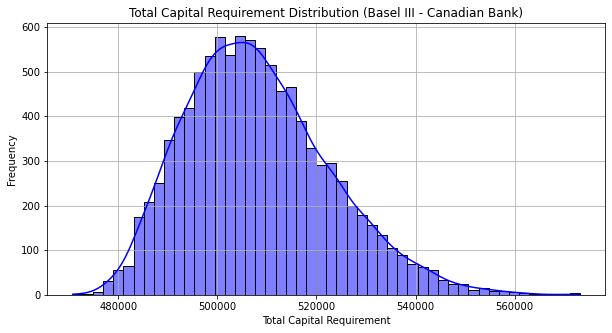

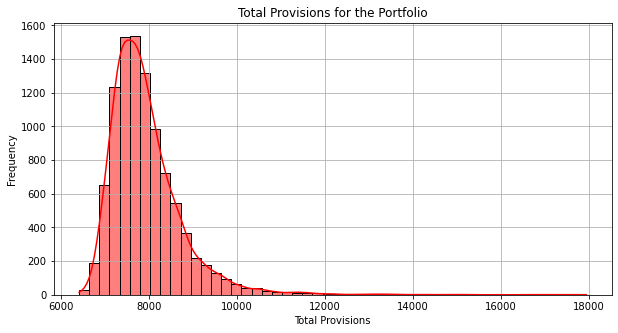

        Simulation  Capital Requirement  Expected Loss
count  10000.00000         10000.000000   10000.000000
mean    4999.50000        508196.054600    7931.853367
std     2886.89568         14606.228425     834.842109
min        0.00000        470813.853709    6409.592946
25%     2499.75000        497564.173393    7390.916886
50%     4999.50000        506727.005437    7768.332079
75%     7499.25000        517218.324195    8264.122927
max     9999.00000        573177.862753   17947.996275


In [ ]:
# Extract PD data from rating sheet
rating.set_index(rating.iloc[:, 0], inplace=True)
rating = rating.iloc[:, 1:]
pd_mean_series = rating.loc["Weighted long-term average"] / 100
pd_std_series = rating.loc["Standard deviation"] / 100

# Apply PD values to bonds
bonds_cap = bonds_2025.copy()
bonds_cap["PD_mean"] = bonds_cap["RATING"].map(pd_mean_series)
bonds_cap["PD_std"] = bonds_cap["RATING"].map(pd_std_series)

# LGD Calculation
bonds_cap['LGD'] = np.where(bonds_cap['SECURITY_LEVEL'].isin(['SEN', 'SS']), 0.45, 0.75)

# Monte Carlo Simulation Setup
num_simulations = 10000
pd_mean = bonds_cap['PD_mean'].fillna(0).values
pd_std = bonds_cap['PD_std'].fillna(0).values
lgd = bonds_cap['LGD'].values
ead = bonds_cap['PRINCIPAL_AMT'].values
maturity_years = bonds_cap['years_to_maturity'].values

# Fix zero PD values
pd_mean_fixed = np.where(pd_mean > 0, pd_mean, 1e-6)
pd_std_fixed = np.where(pd_std > 0, pd_std, 1e-6)

# Monte Carlo Simulation
capitalreq_fixed = np.zeros(num_simulations)
expected_losses = np.zeros(num_simulations)
for i in range(num_simulations):
    if i % 1000 == 0:
        print(f"Simulation {i}/{num_simulations}")
    z_values = np.random.normal(0, 1, len(bonds_cap))
    sigma = np.sqrt(np.log(1 + (pd_std_fixed ** 2 / pd_mean_fixed ** 2)))
    mu = np.log(pd_mean_fixed) - (sigma ** 2 / 2)
    cumulative_probs = norm.cdf(z_values)
    simulated_pds = lognorm.ppf(cumulative_probs, s=sigma, scale=np.exp(mu))
    simulated_pds = np.clip(simulated_pds, 0.0005, 1)
    PD_clipped = np.clip(simulated_pds, 1e-9, 1 - 1e-9)
    R = 0.12 * (1 - np.exp(-50 * PD_clipped)) / (1 - np.exp(-50)) + \
        0.24 * (1 - (1 - np.exp(-50 * PD_clipped)) / (1 - np.exp(-50)))
    b = (0.11852 - 0.05478 * np.log(PD_clipped)) ** 2
    adjustment = (1 + (maturity_years - 2.5) * b) / (1 - 1.5 * b)
    K = (lgd * norm.cdf((norm.ppf(PD_clipped) + np.sqrt(R) * norm.ppf(0.999)) / np.sqrt(1 - R)) - PD_clipped * lgd)
    capitalreq_fixed[i] = np.sum(K * adjustment * ead)
    
    # Calculate Expected Loss (EL) for each simulation
    expected_losses[i] = np.sum(simulated_pds * lgd * ead)

# Results
capitalreq_summary_fixed = pd.DataFrame({
    "Simulation": np.arange(num_simulations),
    "Capital Requirement": capitalreq_fixed,
    "Expected Loss": expected_losses
})

# Save results to CSV for further analysis
capitalreq_summary_fixed.to_csv("capital_requirement_summary.csv", index=False)

# -------------------------------------------
# Descriptive Statistics for EAD and LGD
# -------------------------------------------
ead_stats = pd.Series(ead).describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95, 0.99])
lgd_stats = pd.Series(lgd).describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95, 0.99])

# Print summary statistics for EAD and LGD
print("\n=== Descriptive Statistics for Exposure at Default (EAD) ===")
print(ead_stats)

print("\n=== Descriptive Statistics for Loss Given Default (LGD) ===")
print(lgd_stats)

# -------------------------------------------
# Generate Histograms for Required Outputs
# -------------------------------------------

# Histogram for Total Capital Requirement Distribution (Basel III)
plt.figure(figsize=(10, 5))
sns.histplot(capitalreq_fixed, bins=50, kde=True, color='blue')
plt.xlabel("Total Capital Requirement")
plt.ylabel("Frequency")
plt.title("Total Capital Requirement Distribution (Basel III - Canadian Bank)")
plt.grid(True)
plt.show()

# Histogram for Total Provisions for the Portfolio
plt.figure(figsize=(10, 5))
sns.histplot(expected_losses, bins=50, kde=True, color='red')
plt.xlabel("Total Provisions")
plt.ylabel("Frequency")
plt.title("Total Provisions for the Portfolio")
plt.grid(True)
plt.show()

# -------------------------------------------
# Descriptive Statistics for Capital Requirements and Expected Losses
# -------------------------------------------
print(capitalreq_summary_fixed.describe())